In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import random

from PIL import Image
from collections import Counter
from torchvision import models

import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch
import torch.optim as optim
from torch.utils.data import Dataset
from PIL import Image
import torch.nn as nn

import warnings
warnings.filterwarnings("ignore")

import glob

from sklearn.model_selection import train_test_split

In [ ]:
masks = glob.glob("/content/drive/MyDrive/Dataset_BUSI_with_GT/*/*_mask.png")
images = [mask_images.replace("_mask", "") for mask_images in masks]
labels = []
for image_path in images:
    if 'benign' in image_path:
        labels.append(0)
    elif 'normal' in image_path:
        labels.append(1)
    elif 'malignant' in image_path:
        labels.append(2)

series = list(zip(images, masks, labels))

In [ ]:
def plot_train_label(image_mask):
    image = cv2.imread(image_mask[0])
    mask = cv2.imread(image_mask[1])

    f, axarr = plt.subplots(1, 3, figsize=(5, 5))

    axarr[0].imshow(np.squeeze(image), cmap='gray', origin='lower')
    axarr[0].set_ylabel(image_mask[2], fontsize=14)
    axarr[0].set_xticks([])
    axarr[0].set_yticks([])
    axarr[0].set_title('CT', fontsize=14)

    axarr[1].imshow(np.squeeze(mask), cmap='jet', origin='lower')
    axarr[1].axis('off')
    axarr[1].set_title('Mask', fontsize=14)

    axarr[2].imshow(np.squeeze(image), cmap='gray', alpha=1, origin='lower')
    axarr[2].imshow(np.squeeze(mask), cmap='jet', alpha=0.5, origin='lower')
    axarr[2].axis('off')
    axarr[2].set_title('Overlay', fontsize=14)

    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

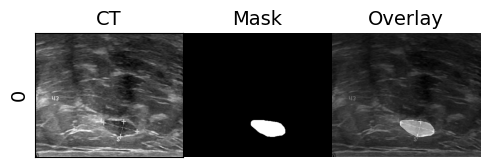

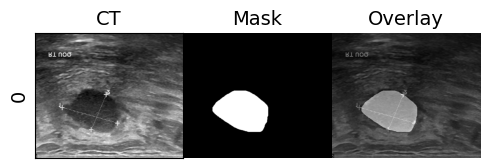

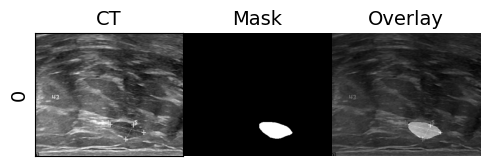

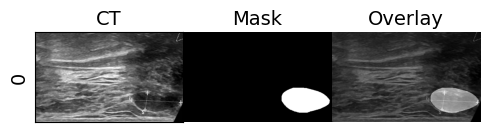

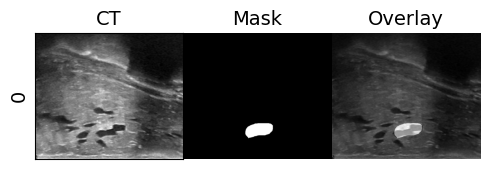

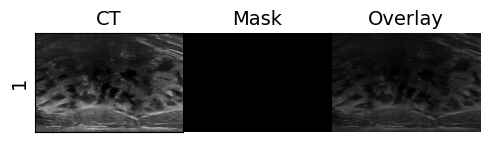

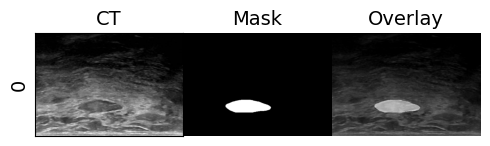

In [ ]:
random_image = random.sample(range(750), 7)
for image in random_image:
    plot_train_label(series[image])

In [ ]:
dataset = pd.DataFrame(series, columns=['image_path', 'mask_path','labels'])

In [ ]:
dataset = dataset[['image_path', 'labels']]

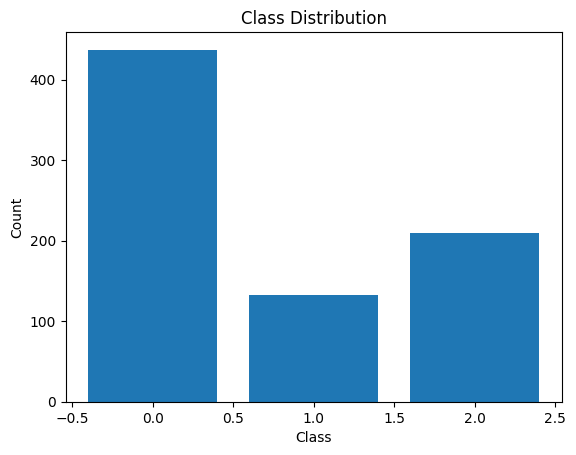

In [ ]:
class_counts = dataset['labels'].value_counts()

plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

In [ ]:
aug_path = 'content/drive/MyDrive/augmented_images/'
image_paths = dataset['image_path'].values
labels = dataset['labels'].values

# Create augmented data folder if it doesn't exist
if not os.path.exists(aug_path):
    os.makedirs(aug_path)

# Count the number of samples in each class
label_counts = Counter(labels)

# Calculate the target number of samples for each class (use the maximum count)
target_count = max(label_counts.values())

# Create image augmentation transforms
combined_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip()
])

In [ ]:
label_counts[0] - label_counts[1]

304

In [ ]:
for i in [1, 2]:
    num_augmentations = label_counts[0] - label_counts[i]
    image_paths = dataset.loc[dataset['labels'] == i, 'image_path'].values
    for j in range(num_augmentations):
        random_index = random.randint(0, len(image_paths) - 1)
        image_path = image_paths[random_index]
        image = Image.open(image_path)
        rotated_image = combined_transform(image.copy())

        rotated_image_np = np.array(rotated_image)
        image_name = os.path.basename(image_path)
        aug_image_path = os.path.join(aug_path, f'{image_name[:-4]}.png')

        cv2.imwrite(aug_image_path, rotated_image_np)

In [ ]:
images = glob.glob("content/drive/MyDrive/augmented_images/*.png")
labels = []
for image_path in images:
    if 'benign' in image_path:
        labels.append(0)
    elif 'normal' in image_path:
        labels.append(1)
    elif 'malignant' in image_path:
        labels.append(2)

new_series = list(zip(images, labels))
dataset_ = pd.DataFrame(new_series, columns=['image_path','labels'])

In [ ]:
concatenated_df = pd.concat([dataset, dataset_], axis=0, ignore_index=True)

In [ ]:
concatenated_df

,image_path,labels
0,/content/drive/MyDrive/Dataset_BUSI_with_GT/ma...,2
1,/content/drive/MyDrive/Dataset_BUSI_with_GT/ma...,2
2,/content/drive/MyDrive/Dataset_BUSI_with_GT/ma...,2
3,/content/drive/MyDrive/Dataset_BUSI_with_GT/ma...,2
4,/content/drive/MyDrive/Dataset_BUSI_with_GT/ma...,2
...,...,...
1035,content/drive/MyDrive/augmented_images/normal ...,1
1036,content/drive/MyDrive/augmented_images/normal ...,1
1037,content/drive/MyDrive/augmented_images/normal ...,1
1038,content/drive/MyDrive/augmented_images/normal ...,1


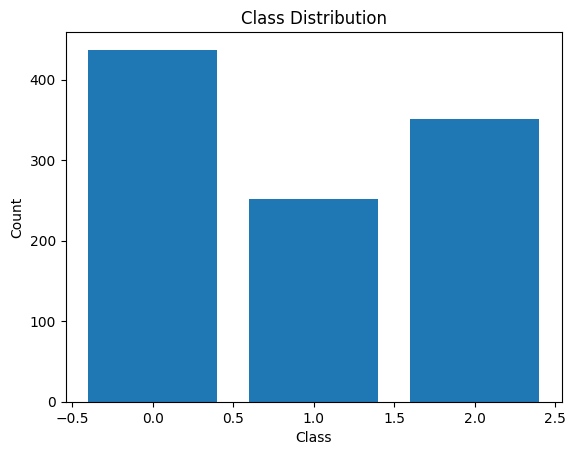

In [ ]:
class_counts = concatenated_df['labels'].value_counts()

plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

In [ ]:
train, test= train_test_split(concatenated_df, test_size=0.3)
test, validation = train_test_split(test, test_size=0.5)

In [ ]:
class CustomImageMaskDataset(Dataset):
    def __init__(self, dataframe, image_transform=None):
        self.data = dataframe
        self.image_transform = image_transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data.iloc[idx]['image_path']
        label = self.data.iloc[idx]['labels']

        image = Image.open(image_path).convert('RGB')

        if self.image_transform:
            image = self.image_transform(image)

        return image, label

In [ ]:
image_size = 256

train_transforms = transforms.Compose([
    transforms.Resize([image_size, image_size]),
    transforms.ToTensor(),
])

val_transforms = transforms.Compose([
    transforms.Resize([image_size, image_size]),
    transforms.ToTensor(),
])


# Create datasets
train_dataset = CustomImageMaskDataset(train, train_transforms)
test_dataset = CustomImageMaskDataset(test, val_transforms)
val_dataset = CustomImageMaskDataset(validation, val_transforms)

# Create DataLoaders
batch_size = 16
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
for batch in train_dataloader:
    # Assuming your dataset returns a tuple (inputs, targets)
    inputs, targets = batch

    # Print the shapes
    print("Input shape:", inputs.shape)
    print("Target shape:", targets.shape)
    break

Input shape: torch.Size([16, 3, 256, 256])
Target shape: torch.Size([16])


In [ ]:
class Trainer:
    def __init__(self, model, optimizer, criterion):
        self.model = model.to(device)
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device
        self.metrics = {'train_loss': [], 'train_accuracy': [], 'val_loss': [], 'val_accuracy': []}

    def train_epoch(self, train_loader):
        self.model.train()
        total_loss = 0.0
        correct_predictions = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(self.device), labels.to(self.device)

            self.optimizer.zero_grad()

            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()

        epoch_loss = total_loss / len(train_loader)
        epoch_accuracy = correct_predictions / len(train_loader.dataset)
        return epoch_loss, epoch_accuracy

    def evaluate(self, val_loader):
        self.model.eval()
        total_loss = 0.0
        correct_predictions = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)

                total_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct_predictions += (predicted == labels).sum().item()

        epoch_loss = total_loss / len(val_loader)
        epoch_accuracy = correct_predictions / len(val_loader.dataset)
        return epoch_loss, epoch_accuracy

    def train(self, train_loader, val_loader, num_epochs=10):
        for epoch in range(num_epochs):
            train_loss, train_accuracy = self.train_epoch(train_loader)
            val_loss, val_accuracy = self.evaluate(val_loader)

            print(f'Epoch {epoch + 1}/{num_epochs} => '
                  f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f} | '
                  f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

            # Save metrics
            self.metrics['train_loss'].append(train_loss)
            self.metrics['train_accuracy'].append(train_accuracy)
            self.metrics['val_loss'].append(val_loss)
            self.metrics['val_accuracy'].append(val_accuracy)

    def get_metrics(self):
        return self.metrics

In [ ]:
from torchvision import models

model_vgg16 = models.vgg16(pretrained=True)
model_vgg19 = models.vgg19(pretrained=True)
model_effnet = models.efficientnet_b7(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 222MB/s]
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 222MB/s]
Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-c5b4e57e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b7_lukemelas-c5b4e57e.pth
100%|██████████| 255M/255M [00:01<00:00, 222MB/s]


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg_classifier = nn.Sequential(
    nn.Flatten(),
    nn.Linear(25088, 4096),
    nn.ReLU(inplace=True),
    nn.Linear(4096, 4096),
    nn.ReLU(inplace=True),
    nn.Linear(4096, 1024),
    nn.ReLU(inplace=True),
    nn.Linear(1024, 3)
)

model_vgg16.classifier = vgg_classifier
model_vgg19.classifier = vgg_classifier

model_effnet.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(2560, 2024),
        nn.ReLU(inplace=True),
        nn.Linear(2024, 1024),
        nn.ReLU(inplace=True),
        nn.Linear(1024, 512),
        nn.ReLU(inplace=True),
        nn.Linear(512, 3)
    )

models_dict = {
    model_vgg16: 'VGG16',
    model_vgg19: 'VGG19',
    model_effnet: 'EfficientNet'
}

for model, name in models_dict.items():
    for param in model.parameters():
        if param.requires_grad:
            break
        else:
            for param in model.parameters():
                param.requires_grad = False

    model.to(device)
    print(f'The model {name} is ready!')
    print('-'*35)

The model VGG16 is ready!
-----------------------------------
The model VGG19 is ready!
-----------------------------------
The model EfficientNet is ready!
-----------------------------------


In [ ]:
def plot_metrics(metrics):
    epochs = range(1, len(metrics['train_loss']) + 1)

    # Plot training and validation loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, metrics['train_loss'], label='Train Loss')
    plt.plot(epochs, metrics['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, metrics['train_accuracy'], label='Train Accuracy')
    plt.plot(epochs, metrics['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

Training and Evaluating for EfficientNet!
-----------------------------------
Epoch 1/20 => Train Loss: 0.9144, Train Accuracy: 0.5412 | Val Loss: 0.9843, Val Accuracy: 0.4679
Epoch 2/20 => Train Loss: 0.4148, Train Accuracy: 0.8420 | Val Loss: 0.9284, Val Accuracy: 0.5577
Epoch 3/20 => Train Loss: 0.2415, Train Accuracy: 0.9190 | Val Loss: 0.7757, Val Accuracy: 0.7308
Epoch 4/20 => Train Loss: 0.1399, Train Accuracy: 0.9478 | Val Loss: 0.8216, Val Accuracy: 0.6987
Epoch 5/20 => Train Loss: 0.0953, Train Accuracy: 0.9725 | Val Loss: 0.7461, Val Accuracy: 0.7308
Epoch 6/20 => Train Loss: 0.1162, Train Accuracy: 0.9657 | Val Loss: 0.5481, Val Accuracy: 0.7564
Epoch 7/20 => Train Loss: 0.0741, Train Accuracy: 0.9780 | Val Loss: 0.5618, Val Accuracy: 0.8013
Epoch 8/20 => Train Loss: 0.1058, Train Accuracy: 0.9698 | Val Loss: 0.7627, Val Accuracy: 0.7564
Epoch 9/20 => Train Loss: 0.0548, Train Accuracy: 0.9863 | Val Loss: 0.4956, Val Accuracy: 0.8205
Epoch 10/20 => Train Loss: 0.0408, Train

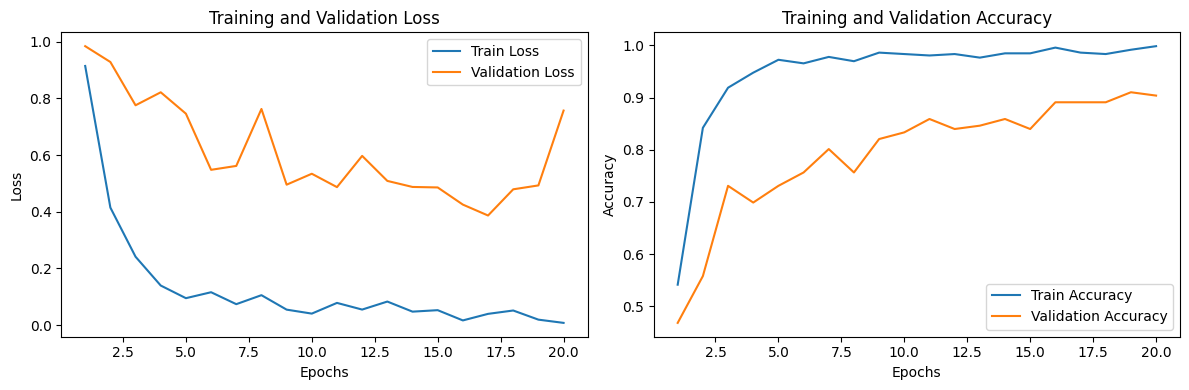

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from torchvision import models
model_effnet = models.efficientnet_b7(pretrained=True)
models_dict = {
    model_effnet: 'EfficientNet'
}
model_effnet.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(2560, 2024),
        nn.ReLU(inplace=True),
        nn.Linear(2024, 1024),
        nn.ReLU(inplace=True),
        nn.Linear(1024, 512),
        nn.ReLU(inplace=True),
        nn.Linear(512, 3)
)
for model, name in models_dict.items():
  print(f'Training and Evaluating for {name}!')
  print('-'*35)
  trainer = Trainer(model, optim.Adam(model.parameters(), lr=0.0001), nn.CrossEntropyLoss())
  trainer.train(train_dataloader, test_dataloader, num_epochs=20)

  metrics = trainer.get_metrics()

    # Test on Validation Set
  correct_predictions = 0
  total_samples = 0
  with torch.no_grad():
      for inputs, labels in val_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    # Calculate accuracy
  accuracy = correct_predictions / total_samples
  print(f'Val Accuracy: {accuracy * 100:.2f}%')

  plot_metrics(metrics)

